<a href="https://colab.research.google.com/github/Ahemd-M/Monte-Carlo-simulation-using-c-/blob/master/deepfake_update_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#important links


1.   all 10GB face data https://drive.google.com/drive/folders/197Ia2ZG1-fBwZRjEUhEpA-hN2yDR9ZN-?usp=sharing
2.   weights folder https://drive.google.com/drive/folders/1xbJtRZhRvfzNItLAcVBeWNi6DLPhi8Xr?usp=sharing
3.   real videos folder https://drive.google.com/drive/folders/1L5ufMnf3KmotOHXsgVHu61g_XORkUzzO?usp=sharing
4.   fake videos folder https://drive.google.com/drive/folders/1y_LKEVeXzrRxdTT_DEhkkh6RQ4JncxN3?usp=sharing



#import package

In [ ]:
!pip install face_recognition

     |████████████████████████████████| 100.2MB 31kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=06e24efe3e2c8dba751348cca6b2a940b1b5408f723eed1275c9a7631ac62831
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline 
import cv2 
import shutil
import random

In [ ]:
import dlib
import face_recognition
import math
import sys
from os.path import basename

In [ ]:
from google.colab import drive
from keras.models import load_model

In [ ]:
drive.mount('/content/drive')

#video preprocessing (face detector)

In [ ]:
def rect_to_bbox(rect):
    """Get the coordinate information of the face rectangle"""
    
    x = rect[3]
    y = rect[0]
    w = rect[1] - x
    h = rect[2] - y
    return (x, y, w, h)

def face_detection(img):
    detect_face = 0
    face_locations = face_recognition.face_locations(img)
         # Extract the picture of the face area and save it
    src_faces = []
    src_face_num = 0
    for (i, rect) in enumerate(face_locations):
        src_face_num = src_face_num + 1
        (x, y, w, h) = rect_to_bbox(rect)
        detect_face = img[y:y+h, x:x+w]
        src_faces.append(detect_face)
    #if len(src_faces) == 0 :
    #  return np.zeros((256,256))
    resize_image = cv2.resize(detect_face,(256,256))
    return resize_image, len(src_faces) 

#prepare data to train and test the model

In [ ]:
#CLASSES = ["FAKE", "REAL"]
img_shape = 256

In [ ]:
print (len(os.listdir(os.path.join('/content/drive/MyDrive/all_data_folder_46/','FAKE'))))

In [ ]:
def split_img_and_lable (train_data):
  test_img = []
  test_img_lable = []
  for image in train_data:
    test_img.append(image[0])
    test_img_lable.append(image[1])
  
  return test_img, test_img_lable

In [ ]:
len( os.listdir(os.path.join(root_dir,'FAKE')))


In [ ]:
def split_data_train_and_test (root_dir, train_ratio, count):
  fake_trainsize = count *train_ratio
  real_trainsize = count *train_ratio
  train_data = []
  test_data = []
  i = 0 
  for image in os.listdir(os.path.join(root_dir,'FAKE')) :
      img = cv2.imread(os.path.join(root_dir,'FAKE',image))     
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = img/255.0
      if i <= fake_trainsize :
          train_data.append([img,0])
      else :
        test_data.append([img,0])
      if i == count :
        break
      
      i += 1 
  i= 0
 
  for image in os.listdir(os.path.join(root_dir,'REAL')) :
      img = cv2.imread(os.path.join(root_dir,'REAL',image)) 
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = img/255.0
      if i <= real_trainsize :
          train_data.append([img,1])
      else :
        test_data.append([img,1])
      i += 1
      if i == count :
        break

  return train_data,test_data

#test the model (prediction phase)

In [ ]:
def predict_image(image,model) : 
  image = image.reshape((-1,256,256,3))
  
  predict = model.predict(image)
  
  #print(predict)
  if predict <= 0.5 :
    return(0)
  else :
    return(1)

def predict_list(image_list,model) :
  pred_list = []
  for img in image_list :
    pred_list.append(predict_image(img,model))
  return pred_list

def get_accuracy_pred(predict_list , label_list ) :
  acc_sum  =0 
  for i in range(0,len(label_list)):
    if predict_list[i] == label_list[i] :
      acc_sum += 1 

  return acc_sum/len(label_list)

def predict_full_video(video_path,model):
    capture_image = cv2.VideoCapture(video_path)
    num_frames =int(capture_image.get(cv2.CAP_PROP_FRAME_COUNT)) 
    frame_each_time=1*math.ceil(capture_image.get(cv2.CAP_PROP_FPS))
    pred_list = []
    for i in range(0, num_frames):
      
      ret = capture_image.grab()
      if i % frame_each_time == 0:   #frame each second
        ret, frame = capture_image.retrieve()
        crop_img , length = face_detection(frame) 
        
        
        if length == 0 :
          continue
          
        else :
         crop_img = crop_img/255.0
         pred_list.append(predict_image(crop_img,model))

    capture_image.release()
    return pred_list
    
def final_video_predict(video_path,model):#<<<<<<<<<<<<<<<<<<<<we will change this method
  pred_list = predict_full_video(video_path,model)
  fake_count = 0
  real_count = 0
  for p in pred_list :
    if p == 0 :
      fake_count += 1
    else :
      real_count += 1
  if fake_count >= real_count :
    return 0 
  else :
    return 1

#save and load model

In [ ]:
def save_model_and_weights(model_name , target_file_name ,path):
  model_name.save(os.path.join(path,target_file_name))

In [ ]:

def load_model_and_weights(full_path):
  return load_model(full_path)



---



---



#**start experment here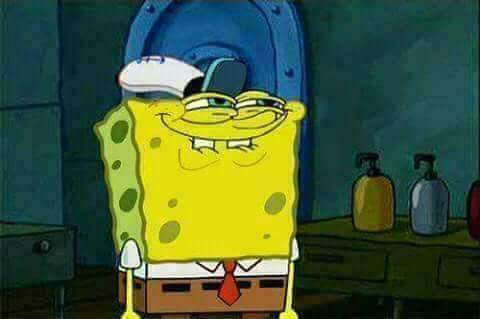**



## 1. get data train and test

In [ ]:
train_data,test_data = split_data_train_and_test('/content/drive/MyDrive/all_data_folder_46/',0.8,2000)#4000 real fake
random.shuffle(train_data)                    
random.shuffle(test_data)                     

In [ ]:
train_img , train_img_lable = split_img_and_lable(train_data)

test_img , test_img_lable = split_img_and_lable(test_data)

print("train_img:",len(train_img))
print("train_img_lable:",len(train_img_lable))
print("test_img:",len(test_img))
print("test_img_lable:",len(test_img_lable))
train_data=[]
test_data = []

train_img: 3202
train_img_lable: 3202
test_img: 799
test_img_lable: 799


In [ ]:
train_img = np.asarray(train_img)
train_img_lable = np.asarray(train_img_lable)

In [ ]:
print(train_img_lable.shape)

(3202,)


In [ ]:
print(train_img.shape)

(3202, 256, 256, 3)


In [ ]:
train_img = np.reshape(train_img, (-1,img_shape, img_shape, 3))

In [ ]:
print(train_img.shape)

(3202, 256, 256, 3)


In [ ]:
test_img = np.asarray(test_img)
test_img_lable = np.asarray(test_img_lable)

In [ ]:
print(test_img_lable.shape)

(799,)


In [ ]:
print(test_img.shape)

(799, 256, 256, 3)


In [ ]:
test_img = np.reshape(test_img, (-1,img_shape, img_shape, 3))

In [ ]:
print(test_img.shape)

(799, 256, 256, 3)


##2. train the model

###2.1 all models here

####2.1.1 meso model

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [ ]:
image_dimensions = {'height':256, 'width':256, 'channels':3}

In [ ]:
meso_model = Sequential()

meso_model.add(Input(shape = (image_dimensions['height'],image_dimensions['width'],image_dimensions['channels'])))

meso_model.add(Conv2D(8, (3, 3), padding='same', activation = 'relu'))
meso_model.add(BatchNormalization())
meso_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

meso_model.add(Conv2D(8, (5, 5), padding='same', activation = 'relu'))
meso_model.add(BatchNormalization())
meso_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

meso_model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
meso_model.add(BatchNormalization())
meso_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

meso_model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
meso_model.add(BatchNormalization())
meso_model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))


meso_model.add(Flatten())  
meso_model.add(Dropout(0.5))
meso_model.add(Dense(16))
meso_model.add(LeakyReLU(alpha=0.1))
meso_model.add(Dropout(0.5))
meso_model.add(Dense(1, activation = 'sigmoid'))


In [ ]:
#load weights
meso_model.load_weights('/content/drive/MyDrive/models h files/Meso4_DF.h5')

In [ ]:
meso_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 8)       224       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 8)       32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       1608      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 8)       32        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        3

In [ ]:
meso_model.compile(optimizer = Adam(lr = 0.001), loss = 'mean_squared_error', metrics = ['accuracy'])

In [ ]:
acc = meso_model.evaluate(test_img, test_img_lable)#0.48 accracy with original weights of meso classifier

25/25 [==============================] - 33s 27ms/step - loss: 0.3017 - accuracy: 0.4687


In [ ]:
#freez feature extraction layers

In [ ]:
#freez before compile****************************************

In [ ]:
for layer in meso_model.layers[:12]:
  layer.trainable = False
  '''freez feature extractor weights'''

In [ ]:
'''
for layer in meso_model.layers[:12]:
  layer.training = False
  
  When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning,
   you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise,
   the updates applied to the non-trainable weights will destroy what the model has learned.
  '''

In [ ]:
meso_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 8)       224       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 8)       32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       1608      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 8)       32        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        3

In [ ]:
meso_model.compile(optimizer = Adam(lr = 0.001), loss = 'mean_squared_error', metrics = ['accuracy'])

In [ ]:
meso_model.fit(train_img,train_img_lable ,validation_data=(test_img, test_img_lable),epochs = 10)

Epoch 1/10
101/101 [==============================] - 38s 53ms/step - loss: 0.2543 - accuracy: 0.5711 - val_loss: 0.2030 - val_accuracy: 0.6971
Epoch 2/10
101/101 [==============================] - 2s 22ms/step - loss: 0.2182 - accuracy: 0.6606 - val_loss: 0.1888 - val_accuracy: 0.7171
Epoch 3/10
101/101 [==============================] - 2s 22ms/step - loss: 0.2016 - accuracy: 0.6793 - val_loss: 0.1874 - val_accuracy: 0.7409
Epoch 4/10
101/101 [==============================] - 2s 22ms/step - loss: 0.1804 - accuracy: 0.7227 - val_loss: 0.1933 - val_accuracy: 0.7697
Epoch 5/10
101/101 [==============================] - 2s 22ms/step - loss: 0.1707 - accuracy: 0.7422 - val_loss: 0.1910 - val_accuracy: 0.7772
Epoch 6/10
101/101 [==============================] - 2s 22ms/step - loss: 0.1644 - accuracy: 0.7591 - val_loss: 0.1916 - val_accuracy: 0.7159
Epoch 7/10
101/101 [==============================] - 2s 23ms/step - loss: 0.1606 - accuracy: 0.7581 - val_loss: 0.2017 - val_accuracy: 0.698

In [ ]:
save_model_and_weights(meso_model ,'pre_meso_model_78_acc_70_val.h5','/content/drive/MyDrive/models h files/')

In [ ]:
loaded_model = load_model_and_weights('/content/drive/MyDrive/models h files/pre_meso_model_78_acc_70_val.h5')

In [ ]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 8)       224       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 8)       32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       1608      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 8)       32        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        3

####2.1.2 VGG16


In [ ]:
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16

In [ ]:
vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet',  input_shape = (image_dimensions['height'],image_dimensions['width'],image_dimensions['channels']))

In [ ]:
vgg.summary()

In [ ]:
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [ ]:
x = vgg.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(16)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.5)(x)
x = Dense(1, activation = 'sigmoid')(x)
pre_model = Model(inputs=vgg.input, outputs=x)

In [ ]:
pre_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [ ]:
pre_model.compile(optimizer = Adam(lr = 0.001), loss = 'mean_squared_error', metrics = ['accuracy'])

In [ ]:
pre_model.fit(train_img,train_img_lable ,validation_data=(test_img, test_img_lable),epochs = 2)

Epoch 1/2
101/101 [==============================] - 91s 492ms/step - loss: 0.2679 - accuracy: 0.5960 - val_loss: 0.2981 - val_accuracy: 0.5544
Epoch 2/2
101/101 [==============================] - 23s 228ms/step - loss: 0.1751 - accuracy: 0.7399 - val_loss: 0.1723 - val_accuracy: 0.7434


In [ ]:
#save model.......

####  2.1.3 model 3



In [ ]:
#import libraries for the model

In [ ]:
#(optional) do some augmentation

In [ ]:
#define archetctre and load weights

In [ ]:
#compile and fit the model

In [ ]:
#save the model

In [ ]:
#go for section 3 and 4 to test on some videos 

In [ ]:
#(optional) after prediction make some fine tuning

####2.1.4 model 4

####2.1.5 model 5

###2.2 fine tuning (ignore it for now)

In [ ]:
'''
for layer in meso_model.layers[:12]:
  layer.training = False
  
  When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning,
   you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise,
   the updates applied to the non-trainable weights will destroy what the model has learned.
  '''

In [ ]:
meso_model.trainable = True

In [ ]:
for layer in meso_model.layers[:6]:
  layer.trainable = False

In [ ]:
meso_model.compile(optimizer = Adam(lr = 0.001), loss = 'mean_squared_error', metrics = ['accuracy'])

In [ ]:
meso_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 8)       224       
_________________________________________________________________
batch_normalization_4 (Batch (None, 256, 256, 8)       32        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 8)       1608      
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 128, 8)       32        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 16)       

In [ ]:
meso_model.fit(train_img,train_img_lable ,validation_data=(test_img, test_img_lable),epochs = 10)

Epoch 1/10
101/101 [==============================] - ETA: 0s - loss: 0.1515 - accuracy: 0.7819

In [ ]:
#ram out

In [ ]:
acc = meso_model.evaluate(test_img, test_img_lable)

25/25 [==============================] - 1s 21ms/step - loss: 0.1930 - accuracy: 0.7660


##3. test on fake video

In [ ]:
predict_full_video('/content/drive/MyDrive/fake_vid/fake1.mp4',loaded_model)

[0, 1, 1, 0, 1, 0, 1, 0, 1, 1]

In [ ]:
predict_full_video('/content/drive/MyDrive/fake_vid/fake2.mp4',loaded_model)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
predict_full_video('/content/drive/MyDrive/fake_vid/fake3.mp4',loaded_model)

[1, 0]

In [ ]:
predict_full_video('/content/drive/MyDrive/fake_vid/fake4.mp4',loaded_model)

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1]

In [ ]:
predict_full_video('/content/drive/MyDrive/fake_vid/fake5.mp4',loaded_model)

[0, 0, 0, 0, 0, 0, 0, 1, 1, 0]

In [ ]:
predict_full_video('/content/drive/MyDrive/fake_vid/fake6.mp4',loaded_model)

[0, 0, 0, 0, 0, 0, 0]

In [ ]:
predict_full_video('/content/drive/MyDrive/fake_vid/fake7.mp4',loaded_model)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
predict_full_video('/content/drive/MyDrive/fake_vid/fake8.mp4',loaded_model)

[0, 0]

In [ ]:
predict_full_video('/content/drive/MyDrive/fake_vid/fake9.mp4',loaded_model)

[]

In [ ]:
predict_full_video('/content/drive/MyDrive/fake_vid/fake10.mp4',loaded_model)

[1, 1, 0, 1, 0, 0, 0, 0, 1, 1]

In [ ]:
predict_full_video('/content/drive/MyDrive/fake_vid/fake11.mp4',loaded_model)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
predict_full_video('/content/drive/MyDrive/fake_vid/fake12.mp4',loaded_model)

[0]

In [ ]:
predict_full_video('/content/drive/MyDrive/fake_vid/fake13.mp4',loaded_model)

[0, 1, 1, 0, 0, 1, 0, 0, 0, 0]

##4. test on real video

In [ ]:
predict_full_video('/content/drive/MyDrive/real_vid/real1.mp4',loaded_model)

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

In [ ]:
predict_full_video('/content/drive/MyDrive/real_vid/real2.mp4',loaded_model)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
predict_full_video('/content/drive/MyDrive/real_vid/real3.mp4',loaded_model)

[1, 1, 0, 1, 1, 0, 0, 0, 0, 0]

In [ ]:
predict_full_video('/content/drive/MyDrive/real_vid/real4.mp4',loaded_model)

[0, 0, 1, 1, 0, 1, 0, 0, 0]

In [ ]:
predict_full_video('/content/drive/MyDrive/real_vid/real5.mp4',loaded_model)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
predict_full_video('',loaded_model)

In [ ]:
predict_full_video('',loaded_model)

In [ ]:
predict_full_video('/content/drive/MyDrive/obama..mp4')

[1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0]

In [ ]:
v = predict_full_video('/content/drive/MyDrive/obama..mp4')

In [ ]:
len(v)

48

In [ ]:
lbl = [0 , 1]

results = {}
for i in lbl:
        results[i] = v.count(i) 
results


{0: 12, 1: 36}

In [ ]:
final_video_predict('/content/drive/MyDrive/obama..mp4')

1

In [ ]:
predict_list(test_img)

[0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,


In [ ]:
test_img_lst = predict_list(test_img)

In [ ]:
test_img_lable

array([0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,

In [ ]:
len(test_img_lable)

799

In [ ]:
aa = 0
count = 0
for img in test_img_lst:
  if test_img_lst[aa] == test_img_lable[aa]:
    count+=1
  aa+=1
print(count)
print('acc = ',count/len(test_img_lst))

612
acc =  0.7659574468085106


TestTest pushpush abdellah